In [103]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import copy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# Set color map to have light blue background
sns.set()

import scipy as sp
import scipy.stats as stats

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

from IPython.display import display, Image
import warnings
warnings.filterwarnings('ignore')

# Analysis of Changes to Electricity Consumption in the Southern California Edison Service Area

# Problem Description

Southern California Edison (SCE) is one of the largest electric utilities in the US, serving most of Southern California. The image below shows the motivation for this project: between 2014 and 2023, the overall amount of electricity consumed by residential SCE customers decreased, despite multiple countervailing factors. Countervailing factors included the global Covid pandemic, a severe drought, and rapid adoption of electric vehicles. 

This project aims to identify the factors that contributed to this decrease in residential electricity consumption.

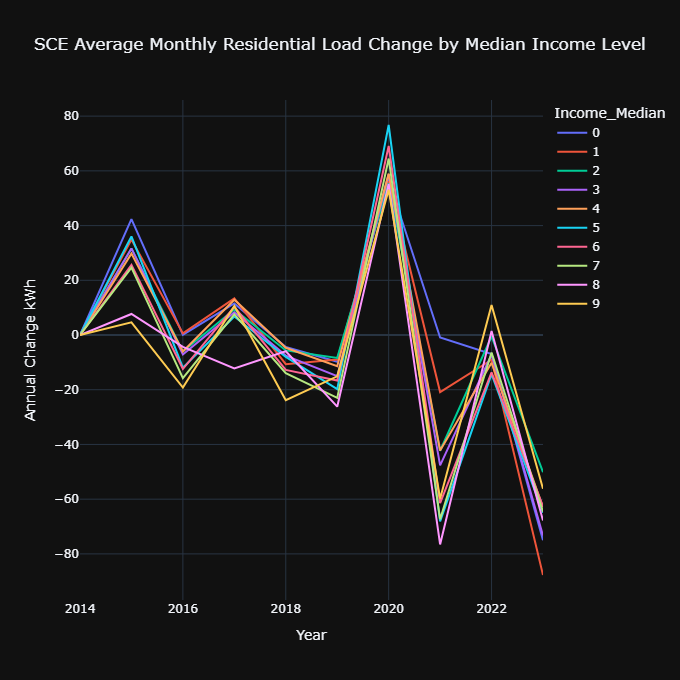

In [95]:
display(Image(filename='trend_overview.png'))

# Hypothesis Formation and Data Strategy

My initial hypothesis: Weather patterns, population socioeconomic changes, rooftop solar adoption, EV adoption, and hidden investments in energy efficiency caused the downward changes in electricity consumption across the SCE service territory between 2014 and 2023. Specifically, the hypotyhesis is that changes in electricity consumption at the customer level can be predicted by these factors (weather, socioeconomic, rooftop solar adoption, EV adoption, and hidden investments in energy efficiency). 

NB: The term 'load' is used in this notebook to refer to electricity consumption.

To identify and understand the factors the contributed to this overall decrease in electricity consumption, I needed to get time series data to capture trends over time. A single snapshot would not explain changes. Then I needed to decide data resolution: since the SCE electricity consumption data was at the zip code level, I need to find time series data also at the zip code level. There was alot of effort spent on collecting, cleaning, and merging the data.

# Data Sources

To investigate this problem, I gathered data from a wide range of sources, for tracking electricity consumption, weather conditions, and socioeconomic factors. The data was collected from the following sources: SCE website provides detailed history of electricity consu,ption by zipcode. Open Meteo provides a from rest api to download historical weather data. The US census provides detailed socioeconomic data at the zip code level. The Lawrence Berkeley National Laboratory publishes annually a national record of rooftop solar installations by zip code. Lastly, the state of California also publishes annually a detailed data set of EV registrations by zipcode. 

# Analysis Approach

The analysis approach is as follows: 1. Initial phase: perform EDA using covariance matrix, decide which variables to include in initial models, conduct OLS regression to test the hypothesis. 2. Classification modeling phase: develop a logistic regression model, SVM linear model, and SVM nonlinear model. Select the most accurate SVM model. 

# EDA

In [93]:
sce7 = pd.read_csv('sce7.csv')
sce7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14311 entries, 0 to 14310
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    14311 non-null  int64  
 1   quarter                 14311 non-null  int64  
 2   TotalkWh                14311 non-null  float64
 3   TotalAccounts           14311 non-null  float64
 4   temperature_2m_max      14311 non-null  float64
 5   temperature_2m_min      14311 non-null  float64
 6   cumulative_solar        14311 non-null  float64
 7   BEV                     14311 non-null  float64
 8   PHEV                    14311 non-null  float64
 9   load_per_account        14311 non-null  float64
 10  delta_totalkwh          14311 non-null  float64
 11  delta_totalaccounts     14311 non-null  float64
 12  delta_load_per_account  14311 non-null  float64
 13  Income_Median           14311 non-null  float64
 14  Pct_Multifamily         14311 non-null

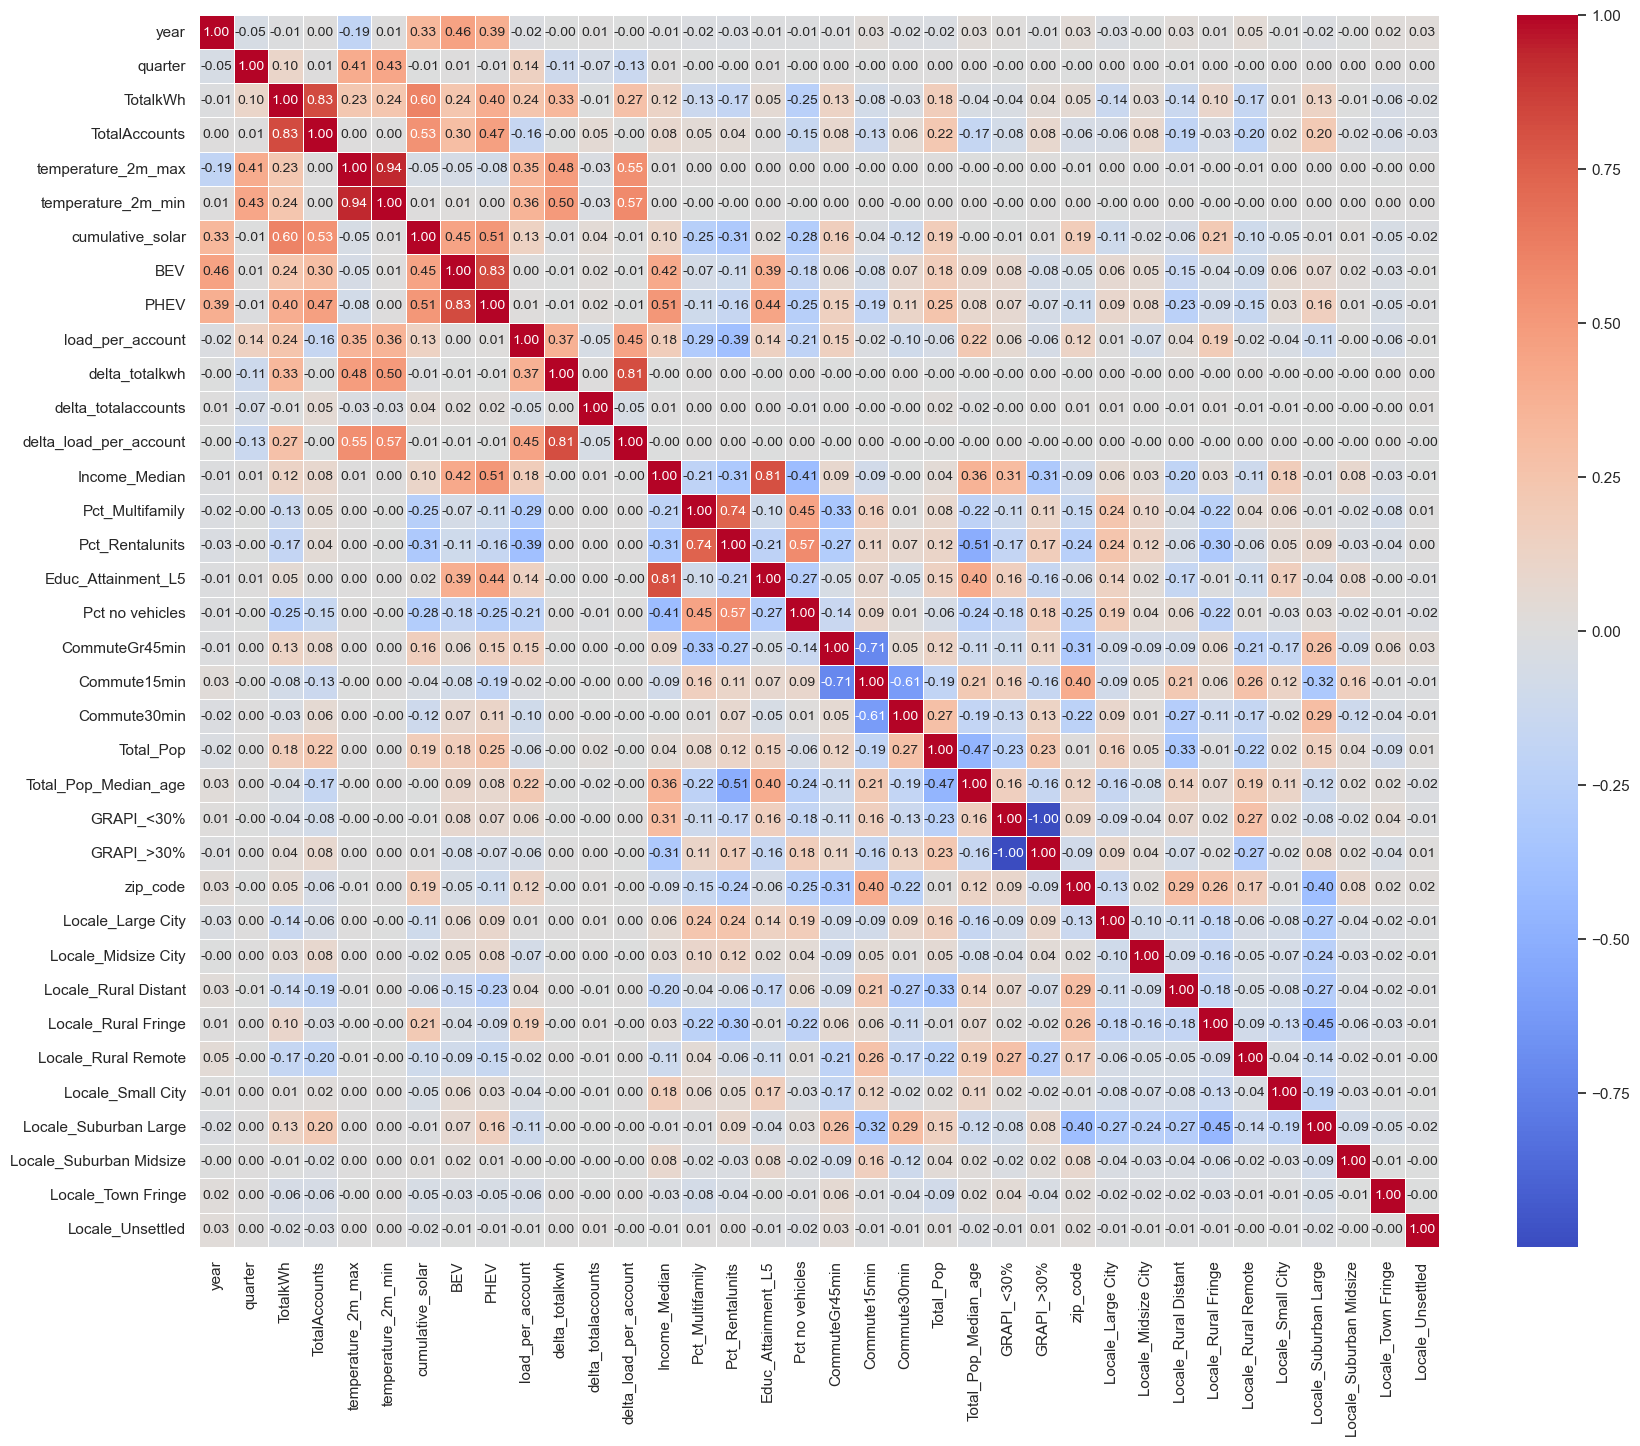

In [ ]:
sce7_encoded = pd.get_dummies(sce7, columns=['Locale'])
boolean_columns = ['Locale_Large City', 'Locale_Midsize City', 'Locale_Rural Distant', 
                   'Locale_Rural Fringe', 'Locale_Rural Remote', 'Locale_Small City',
                   'Locale_Suburban Large', 'Locale_Suburban Midsize', 'Locale_Town Fringe', 
                   'Locale_Unsettled']  

sce7_encoded[boolean_columns] = sce7_encoded[boolean_columns].astype(int)

corr_matrix = sce7_encoded.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.show()

This correlation matrix contains multiple variables that span electricity consumption, weather conditions, and socioeconomic factors. While I could not find data that directly measures energy efficiency investment, I assume that energy efficiency investment can be considered part of the changes within 'year' variable. Since 'Locale' - where the zip code is situated, is a categorical string variable, I one-hot encoded each locale type into new binary columns. Other socioeconomic variables include: income_median, pct_multifamily, pct_rentalunits, educ_attainment_l5 (this is percent of zip code residents with a post graduate degree), pct_no vehicles, commutegr45min, commute15min, total_pop, total_pop_median_age, grapi_<30% (percent of monthly income spent on housing is <30%>),  grapi_<30%. The variable 'quarter' captures seasonality effects of electicity demand. Overall, this set of variables includes those with positive and negative correlations. Some variables themselves have positive and negative correlations.

The delta_totalkwh variable has highest positive correlations with these variables: TotalkWh, temperature_2M_max, temperature_2M_min, load_per_account. 

The delta_totalkwh variable has lowest positive correlations with these variables: quarter, cumulative_solar, BEV registrations, PHEV registrations, and delta_totalaccounts.

# Linear Regression Modeling

In [32]:
#sce6[sce6.isna().any(axis=1)]

In [94]:
sce8 = sce7_encoded.copy()
X = sce8.drop(columns = ['delta_totalkwh'])
y = sce8['delta_totalkwh']  
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         delta_totalkwh   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     1383.
Date:                Fri, 22 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:40:03   Log-Likelihood:            -2.2277e+05
No. Observations:               14311   AIC:                         4.456e+05
Df Residuals:                   14276   BIC:                         4.459e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -4

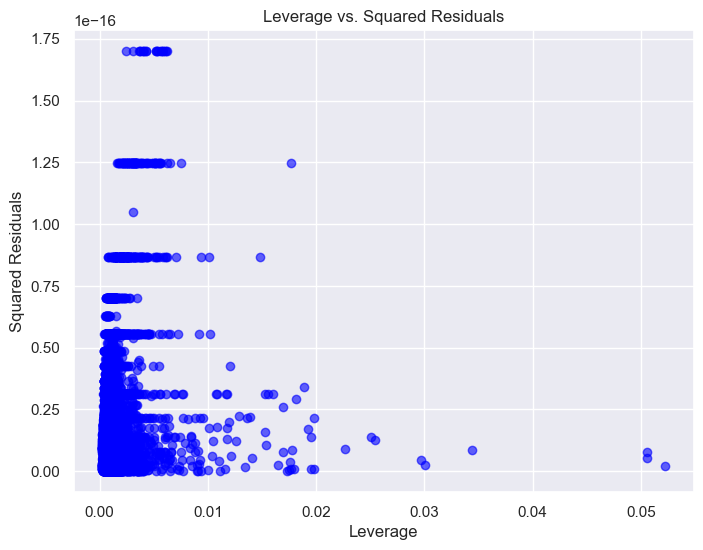

In [95]:
formula = 'delta_totalkwh ~ zip_code + year + quarter + TotalkWh + TotalAccounts + temperature_2m_max+ temperature_2m_min + cumulative_solar + BEV + PHEV + load_per_account + delta_totalkwh + delta_totalaccounts + Income_Median + Pct_Multifamily'
model = smf.ols(formula=formula, data=sce8).fit()

influence = model.get_influence()
leverage = influence.hat_matrix_diag
residuals = model.resid
squared_residuals = residuals**2

plt.figure(figsize=(8, 6))
plt.scatter(leverage, squared_residuals, alpha=0.6, color='blue')
plt.xlabel('Leverage')
plt.ylabel('Squared Residuals')
plt.title('Leverage vs. Squared Residuals')
plt.grid(True)
plt.show()

In [96]:
influence = model.get_influence()

leverage = influence.hat_matrix_diag
residuals = model.resid
squared_residuals = residuals**2

p = len(model.params)
n = len(sce8)  

average_leverage = 2 * (p / n)

high_leverage_points = np.where(leverage > 4*average_leverage)[0]
high_leverage_points = list(high_leverage_points)

std_residual = np.std(residuals)
high_residual_threshold = 4 * std_residual

high_residual_points = np.where(abs(residuals) > high_residual_threshold)[0]
high_residual_points = list(high_residual_points)
high_residual_points.remove(4470)

len(high_residual_points)

96

In [97]:
len(high_leverage_points)

68

In [98]:
X = sce8.drop(columns=["delta_totalkwh", 'Locale_Large City', 'Locale_Midsize City', 'Locale_Rural Distant', 'Locale_Rural Fringe', 'Locale_Rural Remote', 'Locale_Small City', 
'Locale_Suburban Large', 'Locale_Suburban Midsize', 'Locale_Town Fringe', 'Locale_Unsettled', 'GRAPI_<30%', 'GRAPI_>30%', 'temperature_2m_min', 'Pct no vehicles'])  

# Add a constant term for the intercept
X = add_constant(X)

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                  Variable           VIF
0                    const  1.164252e+06
1                     year  1.676477e+00
2                  quarter  1.690821e+00
3                 TotalkWh  8.025708e+00
4            TotalAccounts  7.414299e+00
5       temperature_2m_max  2.320249e+00
6         cumulative_solar  2.731129e+00
7                      BEV  3.666036e+00
8                     PHEV  5.131164e+00
9         load_per_account  2.204032e+00
10     delta_totalaccounts  1.019042e+00
11  delta_load_per_account  2.567714e+00
12           Income_Median  3.852611e+00
13         Pct_Multifamily  2.613054e+00
14         Pct_Rentalunits  3.979129e+00
15      Educ_Attainment_L5  4.151712e+00
16          CommuteGr45min  4.664536e+00
17            Commute15min  6.930789e+00
18            Commute30min  3.507931e+00
19               Total_Pop  2.052206e+00
20    Total_Pop_Median_age  2.768343e+00
21                zip_code  1.519318e+00


In [99]:
sce9 = sce8.drop(columns = ['Locale_Large City', 'Locale_Midsize City', 'Locale_Rural Distant', 'Locale_Rural Fringe', 'Locale_Rural Remote', 'Locale_Small City', 
'Locale_Suburban Large', 'Locale_Suburban Midsize', 'Locale_Town Fringe', 'Locale_Unsettled','GRAPI_<30%', 'GRAPI_>30%','temperature_2m_min','Pct no vehicles','Income_Median', ])
X = sce9.drop(columns = ['delta_totalkwh'])
y = sce9['delta_totalkwh']  
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on X_train
ols_model = sm.OLS(y_train, X_train).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:         delta_totalkwh   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     1923.
Date:                Fri, 22 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:40:13   Log-Likelihood:            -1.7820e+05
No. Observations:               11448   AIC:                         3.564e+05
Df Residuals:                   11427   BIC:                         3.566e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -6.71

In [ ]:
#  Make predictions on the test set
y_pred = ols_model.predict(X_test)

# Evaluate the performance on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R^2): {r2}")

Root Mean Squared Error (RMSE): 1441213.9494757643
R-squared (R^2): 0.7341052763393284


## Linear Regression Model Quality

Out of >14,500 rows, only 96 rows have high residuals and 68 rows have high leverage. I decided not to remove these rows, given the unusual events of a global Covid pandemic and severe drought, to keep some inherent variation in the data. I removed all the locale columns, because they had inf vif values. 'GRAPI_<30%', 'GRAPI_>30%' columns were also removed due to large vif values. During OLS modeling on this reduced data set, I also removed temperature_2m_min','Pct no vehicles','Income_Median' columns due to their excessively large p_values. Overall, the large condition number of this model indicates persisting multicollinearity.

Another concern is overfitting. While R squared between y_test and y_pred is good at 0.73, the RMSE value is very large. Clearly, the model lacks generalizability. However, given the scale of electricity consumption for one of the most densely populated areas of the US, a large error is also not unexpected.

In [70]:
# Extract t-values and p-vt_values = results.tvalues
t_values = results.tvalues
p_values = results.pvalues
coefficients = results.params

# Combine results into a DataFrame
t_test_results = pd.DataFrame({
    "Predictor": coefficients.index,
    "Coefficient": coefficients.values,
    "t-Statistic": t_values.values,
    "P-Value": p_values.values
})

t_test_results2 = t_test_results.sort_values(by='Coefficient')
t_test_results2 

,Predictor,Coefficient,t-Statistic,P-Value
0,const,-7.472235e+07,-5.977715,2.316779e-09
2,quarter,-2.647838e+05,-19.554292,4.743190e-84
16,Commute15min,-1.566844e+04,-5.815900,6.159766e-09
15,CommuteGr45min,-1.376849e+04,-4.533591,5.846015e-06
14,Educ_Attainment_L5,-7.599425e+03,-3.873816,1.076222e-04
19,Total_Pop_Median_age,-6.562702e+03,-2.366468,1.797198e-02
17,Commute30min,-5.228538e+03,-1.844298,6.516044e-02
9,load_per_account,-2.066134e+03,-31.228756,3.673150e-207
6,cumulative_solar,-4.490765e+02,-23.011950,4.326927e-115
4,TotalAccounts,-3.169314e+02,-66.057468,0.000000e+00


## Linear Regression Model Hypothesis Testing

P_values are within acceptable ranges after revising the model. T-statistics show highest absolute values for the following variables: delta_load_per_account, TotalkWh, TotalAccounts, load_per_account, cumulative_solar, and quarter. Within these important predictor variables, only delta_load_per_account and TotalkWh had an overall upward effect on delta_totalkwh. 

# Classification Modeling

Since per the t-test results, delta_load_per_account is the most significant predictor of delta_totalkwh, classification modeling will focus on predicting delta_load_per_account. delta_totalkwh will be removed from the model, in order to identify other variables that strongly predict delta_load_per_account. Classification modeling will focus on logistic regression and the SVM machine learning technique.

                 Feature  Coefficient
2               TotalkWh     2.186461
4     temperature_2m_max     1.396379
0                   year     0.703224
8       load_per_account     0.425130
11       Pct_Rentalunits     0.320248
7                   PHEV     0.219792
10       Pct_Multifamily     0.037081
14          Commute15min     0.036368
17  Total_Pop_Median_age     0.008490
18              zip_code     0.003622
9    delta_totalaccounts    -0.072824
15          Commute30min    -0.072883
12    Educ_Attainment_L5    -0.096302
16             Total_Pop    -0.160737
13        CommuteGr45min    -0.170037
6                    BEV    -0.338246
5       cumulative_solar    -0.624201
1                quarter    -0.900081
3          TotalAccounts    -1.374167
Accuracy: 0.8292001397135872


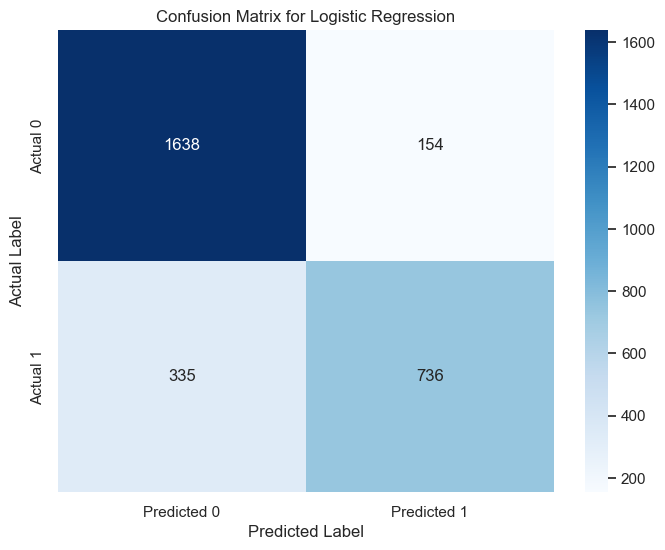

ROC AUC: 0.85


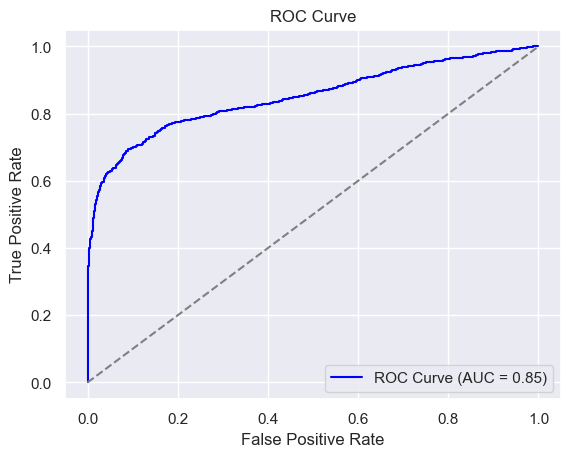

In [101]:
# Prepare the data
sce10 = sce9.drop(columns=['delta_load_per_account', 'delta_totalkwh',]).copy()
sce9['delta_load_per_account_binary'] = (sce9['delta_load_per_account'] > 0).astype(int)

# Selecting features for scaling
features = ['year', 'quarter', 'TotalkWh', 'TotalAccounts', 'temperature_2m_max',
       'cumulative_solar', 'BEV', 'PHEV', 'load_per_account', 
       'delta_totalaccounts',  'Pct_Multifamily',
       'Pct_Rentalunits', 'Educ_Attainment_L5', 'CommuteGr45min',
       'Commute15min', 'Commute30min', 'Total_Pop', 'Total_Pop_Median_age',
       'zip_code']

# Check features
missing_features = [feature for feature in features if feature not in sce10.columns]
if missing_features:
    print("Missing features:", missing_features)

# Scale features
scaler = StandardScaler()
sce10[features] = scaler.fit_transform(sce10[features])

# Features and target variable
X = sce10[features]
y = sce9['delta_load_per_account_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Coefficients
coefficients = model.coef_[0]
feature_names = X_train.columns.tolist()
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients}).sort_values(by='Coefficient', ascending=False)

# Predictions
y_pred = model.predict(X_test)

# Display coefficients and accuracy
print(coeff_df)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Accuracy: 0.8368843870066364


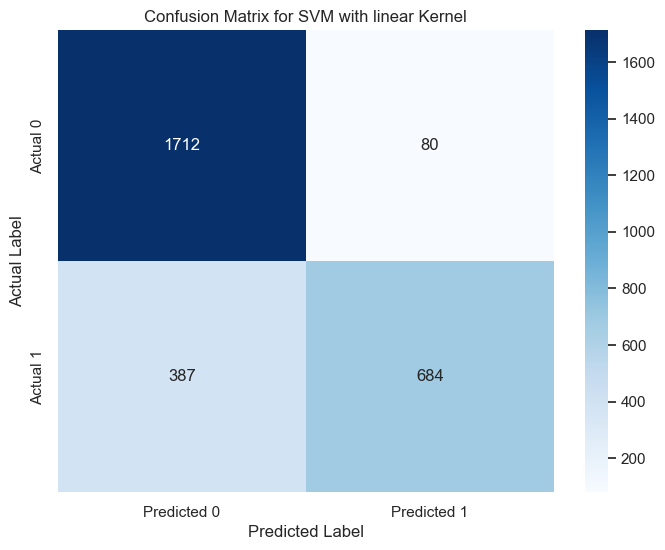

ROC AUC: 0.82


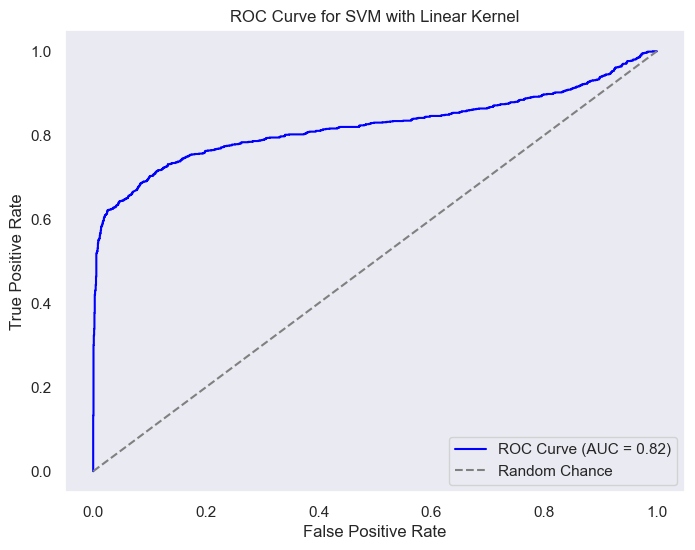

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score

# Initialize the SVM classifier with a linear kernel
#svm_classifier = SVC(kernel='linear')
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)

# Train the model
svm_classifier.fit(X_train, y_train)

# Predictions
y_pred_linear = svm_classifier.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_linear))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_linear)

# Plotting using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for SVM with linear Kernel')
plt.show()

# ROC Curve
# Get probability estimates for the test set
y_prob = svm_classifier.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC: {roc_auc:.2f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM with Linear Kernel')
plt.legend(loc='lower right')
plt.grid()
plt.show()

RBF Kernel Accuracy: 0.8871812783793224


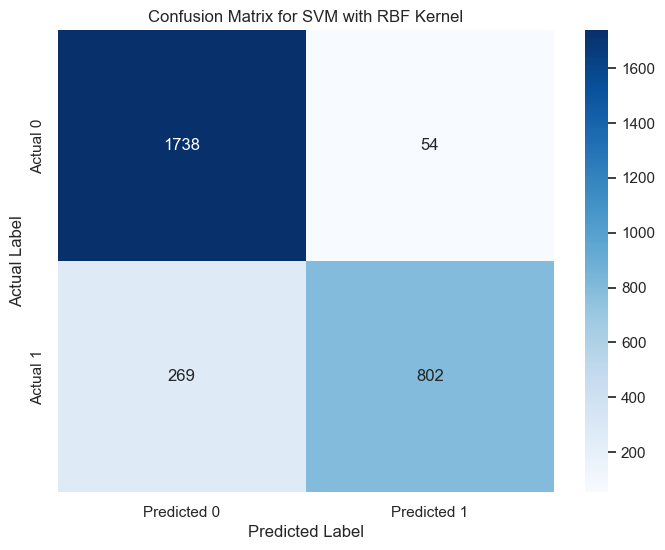

ROC AUC for RBF Kernel: 0.95


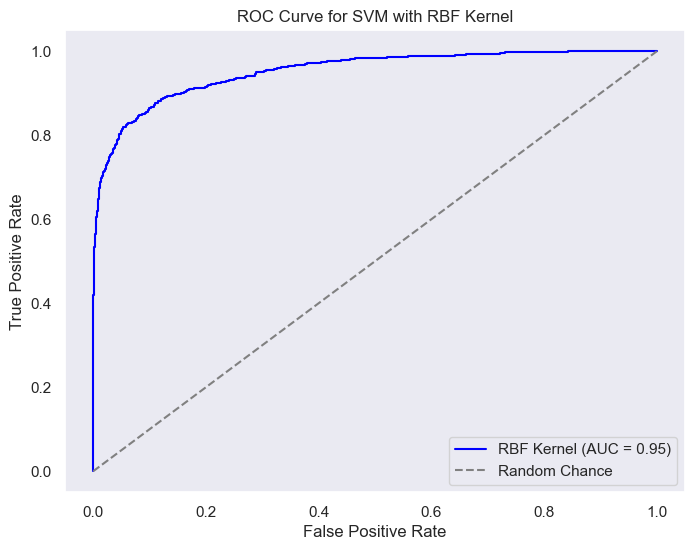

In [89]:
# Using the RBF kernel
#svm_rbf = SVC(kernel='rbf')
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)

print("RBF Kernel Accuracy:", accuracy_score(y_test, y_pred_rbf))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_rbf)

# Plotting using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for SVM with RBF Kernel')
plt.show()

# Get probability estimates for the test set
y_prob_rbf = svm_rbf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Compute the ROC curve
fpr_rbf, tpr_rbf, thresholds_rbf = roc_curve(y_test, y_prob_rbf)

# Compute the AUC score
roc_auc_rbf = roc_auc_score(y_test, y_prob_rbf)
print(f"ROC AUC for RBF Kernel: {roc_auc_rbf:.2f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rbf, tpr_rbf, color='blue', label=f'RBF Kernel (AUC = {roc_auc_rbf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM with RBF Kernel')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Compared to the logistic regression model, SVM with linear kernel had a slightly larger accuracy score but a lower ROC AUC score. The SVM with rbf kernel had the highest accuracy and highest ROC AUC score, therefore this model is selected as the best classifier. 

# Conclusion

This study applied linear regression, logistic regression, and SVM classification modeling to test the relationship between the change in total kWh and a set of weather and socioeconomic factors. Multicollinearity and overfitting were seen in the linear regression model. Despite these limitations, delta_load_per_account was found to be the most important predictor. 

Classification modeling for delta_load_per_account_binary showed that the SVM with the RBF kernel had the highest accuracy and AUC score. Per the logistic regression model, the most important features causing delta_load_per_account_binary to increase were: TotalkWh, temperature_2m_max, and year. The most important features causing delta_load_per_account_binary to decrease were: Total accounts, quarter, and cumulative_solar.

Overall, these models are an interesting start to this investigation. In future work, additional data sources will be useful, including more detailed weather data per zipcode and more detailed data about energy efficiency investments. Additionally, removing variables with excessive multicollinearity will be useful.